In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import functions as f


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

s_cal = pd.read_csv('./calendar.csv')
s_list = pd.read_csv('./listings.csv')
s_rev = pd.read_csv('./reviews.csv')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Evaluating Price
In this section we will take a look at the features that influence price.  Specifically, we will investigate the differences between the inclusive price and the price as it is listed in the data to determine if there is evidence that the cleaning fee is used to list a lower price, but still generate the same payment.

We will find that when evaluating the total inclusive price that the most important factors are the room type, neighborhood, bathrooms and bedrooms as we would have expected.  Additionally the single most important factor for the inclusive price is if you are renting the entire house/ appartment.

However, when evaluating the price separate from the cleaning fee, the most important features are the bed type and the room type.  This is not an intuitive result, and it seems more likely that the cleaning fee is indeed separated out from the listing price for marketing reasons.

Below we will explore if there is any correlation between the cleaning fee and the reported cleanliness reviews

**Note:**
- The inclusive price is the price plus the cleaning fee
- The data is constrained to only listings that were occupied between 10% and 90% of the year to exclued any differences between properties that were occupied in the extreme

### Evaluating the variables that influence the total inclusive price

Number of included features:  42
The r-squared score for the model train was 0.7503696120542738 on 931 values.
The r-squared score for the model test was 0.7621981125960966 on 400 values. 

The top 20 coefficents for the model were: 
                                              est_int      coefs  abs_coefs
25                         room_type_Entire home/apt  86.080927  86.080927
16              neighbourhood_group_cleansed_Cascade  72.820537  72.820537
20           neighbourhood_group_cleansed_Queen Anne  63.677873  63.677873
18             neighbourhood_group_cleansed_Downtown  62.532960  62.532960
24                                property_type_Loft  60.043343  60.043343
15         neighbourhood_group_cleansed_Capitol Hill  53.097990  53.097990
4                                          bathrooms  50.413232  50.413232
5                                           bedrooms  39.844851  39.844851
34                                           hot tub  39.552755  39.552755
40             

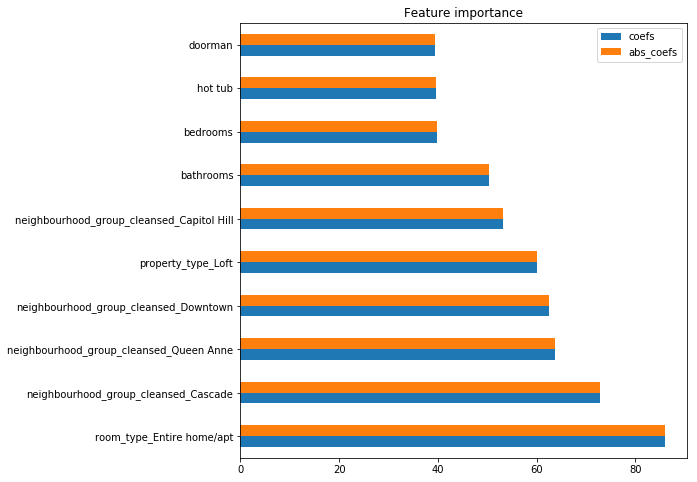

In [4]:
price_incl_data = f.create_dataset(s_list, s_cal, s_rev, 'price_incl', price_inclusive = 'y')
price_incl_data = f.get_feature_set(price_incl_data, 'price_incl')
price_incl_data = f.constrain_occupancy(price_incl_data, 0.1, 0.9)
print('Number of included features: ', price_incl_data.shape[1])

X_price_incl_train, X_price_incl_test, y_price_incl_train, y_price_incl_test, y_price_incl_test_preds, y_price_incl_train_preds, price_incl_model = f.get_model(price_incl_data,'price_incl')
print("The r-squared score for the model train was {} on {} values.".format(r2_score(y_price_incl_train, y_price_incl_train_preds), len(y_price_incl_train)))
print("The r-squared score for the model test was {} on {} values.".format(r2_score(y_price_incl_test, y_price_incl_test_preds), len(y_price_incl_test)), '\n')
coef_df = f.coef_weights(price_incl_model, price_incl_model.coef_, X_price_incl_train)
print('The top 20 coefficents for the model were:', '\n', coef_df.head(20))

matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
viz = coef_df.head(10).plot(kind = "barh")
plt.title("Feature importance")
viz.set_yticklabels(coef_df['est_int'].to_list());

### Evaluating the variables that influence the stated price

Number of included features:  55
The r-squared score for the model train was 0.6797479702017217 on 1238 values.
The r-squared score for the model test was 0.6092817608824177 on 531 values. 

The top 20 coefficents for the model were: 
                                              est_int         coefs  \
39                                    bed_type_Couch  6.102713e+13   
38                                   bed_type_Airbed  6.102713e+13   
40                                    bed_type_Futon  6.102713e+13   
42                                 bed_type_Real Bed  6.102713e+13   
41                            bed_type_Pull-out Sofa  6.102713e+13   
35                         room_type_Entire home/apt  1.714909e+13   
36                            room_type_Private room  1.714909e+13   
37                             room_type_Shared room  1.714909e+13   
22            neighbourhood_group_cleansed_Northgate -1.090427e+12   
17             neighbourhood_group_cleansed_Delridge -1.090427e+

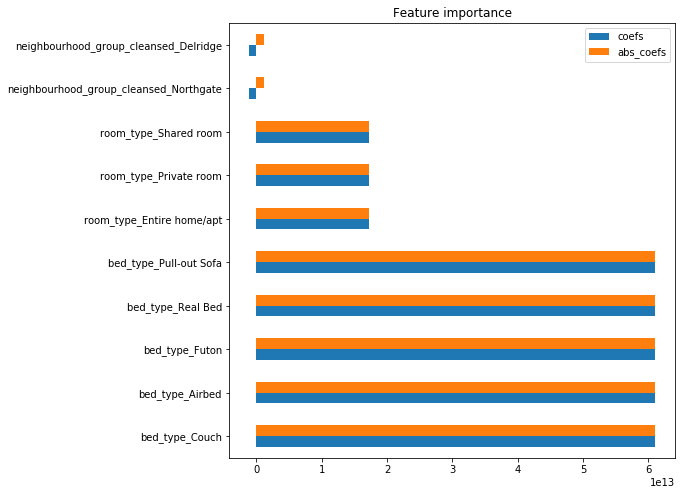

In [5]:
price_data = f.create_dataset(s_list, s_cal, s_rev, 'price', price_inclusive = 'n')
price_data = f.get_feature_set(price_data, 'price')
price_data = f.constrain_occupancy(price_data, 0.1, 0.9)
print('Number of included features: ', price_data.shape[1])
X_price_train, X_price_test, y_price_train, y_price_test, y_price_test_preds, y_price_train_preds, price_model = f.get_model(price_data,'price')
print("The r-squared score for the model train was {} on {} values.".format(r2_score(y_price_train, y_price_train_preds), len(y_price_train)))
print("The r-squared score for the model test was {} on {} values.".format(r2_score(y_price_test, y_price_test_preds), len(y_price_test)), '\n')
coef_df = f.coef_weights(price_model, price_model.coef_, X_price_train)
print('The top 20 coefficents for the model were:', '\n', coef_df.head(20))

matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
viz = coef_df.head(10).plot(kind = "barh")
plt.title("Feature importance")
viz.set_yticklabels(coef_df['est_int'].to_list());

## Evaluating Reviews
In this section we will take a look at the listing reviews.  First we will explore what factors go into the overal review score.  Next we look into the cleanliness review in greater detail.  Specifically, we will investigate what are the most important features for the cleanliness score and what correlation (if any) is there between the cleanliness of the listing and the cleaning fee charged.

We will find that the most important features to obtain an overall high review are the value of the stay, the cleanliness of the unit, the accuracy of the description and the communication of the host.  Particularly for the the cleanliness rating, it was most important for host to be responsive. So, the communication and responsiveness of the host is a very high factor in ratings above and beyond the property itself.  Interestingly, allowing pets or smoking and having a kitchen make for the possiblity of lower cleanliness scores.  

We did not find a specific correlation between the charging of a cleaning fee and the cleanliness rating of the unit.  However, ~89% of units that did not charge a cleaning fee recieved cleanliness ratings above a 9.  This is compared against a ~94% of ratings at or above 9 for those who charged a fee.
**Notes:**
- The data is constrained to only listings that were occupied between 10% and 90% of the year to exclued any differences between properties that were occupied in the extreme

### Evaluating the variables that influence overall review

Number of included features:  18
The r-squared score for the model train was 0.6958127565742291 on 1065 values.
The r-squared score for the model test was 0.6403776960983408 on 457 values. 

The top 20 coefficents for the model were: 
                                     est_int         coefs     abs_coefs
8                       review_scores_value  3.106785e+00  3.106785e+00
4                 review_scores_cleanliness  2.346061e+00  2.346061e+00
3                    review_scores_accuracy  1.615733e+00  1.615733e+00
6               review_scores_communication  1.353853e+00  1.353853e+00
10     neighbourhood_group_cleansed_Cascade -1.193325e+00  1.193325e+00
7                    review_scores_location  8.662020e-01  8.662020e-01
11  neighbourhood_group_cleansed_Queen Anne -7.377023e-01  7.377023e-01
5                     review_scores_checkin  6.624238e-01  6.624238e-01
14                                  shampoo  5.800834e-01  5.800834e-01
13                              safety card 

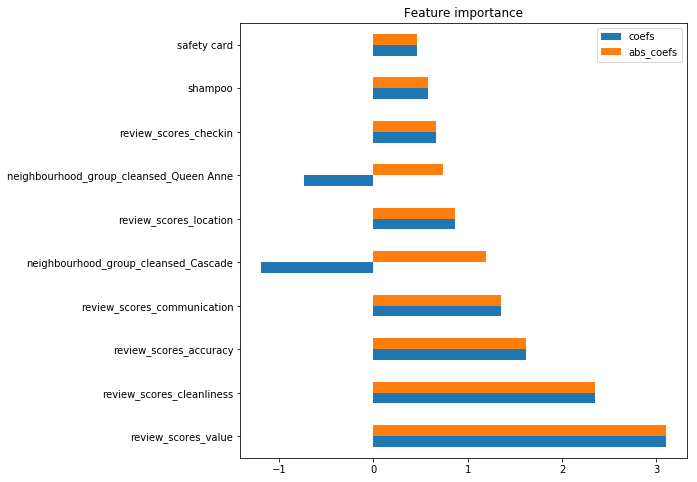

In [6]:
review_data = f.create_dataset(s_list, s_cal, s_rev, 'review_scores_rating', price_inclusive = 'n')
#review_data = data[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
#                   'review_scores_communication','review_scores_location','review_scores_value']]
review_data = f.constrain_occupancy(review_data, 0.1, 0.9)
review_data = f.get_feature_set(review_data, 'review_scores_rating')


print('Number of included features: ', review_data.shape[1])
X_review_train, X_review_test, y_review_train, y_review_test, y_review_test_preds, y_review_train_preds, review_model = f.get_model(review_data,'review_scores_rating')
print("The r-squared score for the model train was {} on {} values.".format(r2_score(y_review_train, y_review_train_preds), len(y_review_train)))
print("The r-squared score for the model test was {} on {} values.".format(r2_score(y_review_test, y_review_test_preds), len(y_review_test)), '\n')
coef_df = f.coef_weights(review_model, review_model.coef_, X_review_train)
print('The top 20 coefficents for the model were:', '\n', coef_df.head(20))

matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
viz = coef_df.head(10).plot(kind = "barh")
plt.title("Feature importance")
viz.set_yticklabels(coef_df['est_int'].to_list());

### Evaluating the variables that influence cleanliness review

Number of included features:  21
The r-squared score for the model train was 0.5236353501843645 on 1062 values.
The r-squared score for the model test was 0.5225468281422715 on 456 values. 

The top 20 coefficents for the model were: 
                                              est_int     coefs  abs_coefs
0                                 host_response_rate  0.637097   0.637097
10  neighbourhood_group_cleansed_University District -0.357009   0.357009
18                                   smoking allowed -0.227084   0.227084
14                                      pets allowed -0.179255   0.179255
6                              review_scores_checkin  0.162480   0.162480
17                                              pool  0.161062   0.161062
5                             review_scores_accuracy  0.146741   0.146741
11                                           kitchen -0.139439   0.139439
8                                review_scores_value  0.131613   0.131613
15                      

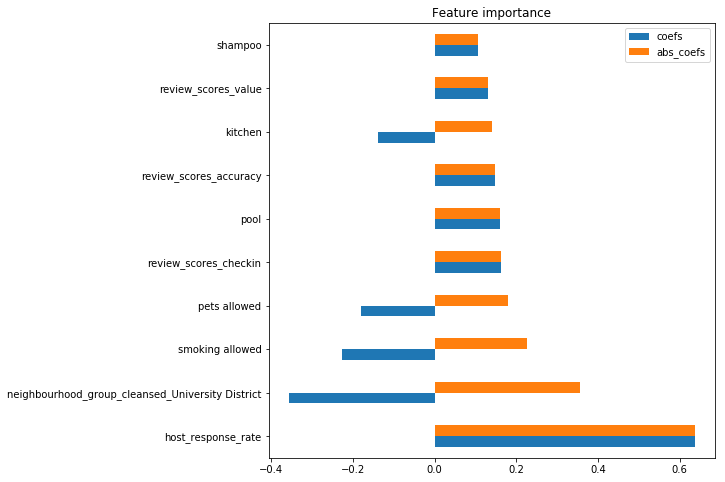

In [7]:
clean_review_data = f.create_dataset(s_list, s_cal, s_rev, 'review_scores_cleanliness', price_inclusive = 'n', clean_fee_binary = 'y')
clean_review_data = f.constrain_occupancy(clean_review_data, 0.1, 0.9)
clean_review_data = f.get_feature_set(clean_review_data, 'review_scores_cleanliness', pmax_lower_bound = 0.05)

print('Number of included features: ', clean_review_data.shape[1])
X_clean_review_train, X_clean_review_test, y_clean_review_train, y_clean_review_test, y_clean_review_test_preds, y_clean_review_train_preds, clean_review_model = f.get_model(clean_review_data,'review_scores_cleanliness')
print("The r-squared score for the model train was {} on {} values.".format(r2_score(y_clean_review_train, y_clean_review_train_preds), len(y_clean_review_train)))
print("The r-squared score for the model test was {} on {} values.".format(r2_score(y_clean_review_test, y_clean_review_test_preds), len(y_clean_review_test)), '\n')
coef_df = f.coef_weights(clean_review_model, clean_review_model.coef_, X_clean_review_train)
print('The top 20 coefficents for the model were:', '\n', coef_df.head(20))

matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
viz = coef_df.head(10).plot(kind = "barh")
plt.title("Feature importance")
viz.set_yticklabels(coef_df['est_int'].to_list());

In [8]:
clean_and_fee = f.create_dataset(s_list, s_cal, s_rev, 'review_scores_cleanliness', price_inclusive = 'n', clean_fee_binary = 'n')
clean_and_fee = f.constrain_occupancy(clean_and_fee, 0.1, 0.9)

num_0 = (clean_and_fee.query('cleaning_fee == 0').shape[0]) 
num_100 = (clean_and_fee.query('cleaning_fee > 0 & cleaning_fee <= 100').shape[0])
num_200 = (clean_and_fee.query('cleaning_fee > 100 & cleaning_fee <= 200').shape[0])
num_300 = (clean_and_fee.query('cleaning_fee > 200 & cleaning_fee <= 300').shape[0])

prop_0 = (clean_and_fee.query('cleaning_fee == 0 & review_scores_cleanliness >= 9').shape[0])/(clean_and_fee.query('cleaning_fee == 0').shape[0])
prop_100 = (clean_and_fee.query('cleaning_fee > 0 & cleaning_fee <= 100 & review_scores_cleanliness >= 9').shape[0])/(clean_and_fee.query('cleaning_fee > 0 & cleaning_fee <= 100').shape[0])
prop_200 = (clean_and_fee.query('cleaning_fee > 100 & cleaning_fee <= 200 & review_scores_cleanliness >= 9').shape[0])/(clean_and_fee.query('cleaning_fee > 100 & cleaning_fee <= 200').shape[0])
prop_300 = (clean_and_fee.query('cleaning_fee > 200 & cleaning_fee <= 300 & review_scores_cleanliness >= 9').shape[0])/(clean_and_fee.query('cleaning_fee > 200 & cleaning_fee <= 300').shape[0])

print('proportion of cleanliness scores at or greater than 9 for 0 cleaning fee: ', prop_0, ' out of ', num_0)
print('proportion of cleanliness scores at or greater than 9 for 1$ to $100 cleaning fee: ', prop_100,' out of ', num_100)
print('proportion of cleanliness scores at or greater than 9 for $101 to $200 cleaning fee: ', prop_200,' out of ', num_200)
print('proportion of cleanliness scores at or greater than 9 for $201 to $300 cleaning fee: ', prop_300,' out of ', num_300,'\n')

print('proportion of cleanliness scores greate than a 9 for everyone who chareged a fee', 
      clean_and_fee.query('cleaning_fee > 0 & review_scores_cleanliness>=9').shape[0]/clean_and_fee.query('cleaning_fee > 0').shape[0])

proportion of cleanliness scores at or greater than 9 for 0 cleaning fee:  0.8904899135446686  out of  347
proportion of cleanliness scores at or greater than 9 for 1$ to $100 cleaning fee:  0.9351403678606002  out of  1033
proportion of cleanliness scores at or greater than 9 for $101 to $200 cleaning fee:  0.9823008849557522  out of  113
proportion of cleanliness scores at or greater than 9 for $201 to $300 cleaning fee:  0.88  out of  25 

proportion of cleanliness scores greate than a 9 for everyone who chareged a fee 0.9385140905209223


In [9]:
#Correlation between actual price and cleanliness
clean_and_fee_red = pd.DataFrame(clean_and_fee[['review_scores_cleanliness','cleaning_fee']])
print('Correlation of review with fee binary: \n', clean_and_fee_red.corr())

clean_review_data_red = pd.DataFrame(clean_review_data[['review_scores_cleanliness','cleaning_fee']])
print('Correlation of review with fee price: \n', clean_review_data_red.corr())

Correlation of review with fee binary: 
                            review_scores_cleanliness  cleaning_fee
review_scores_cleanliness                   1.000000      0.059275
cleaning_fee                                0.059275      1.000000
Correlation of review with fee price: 
                            review_scores_cleanliness  cleaning_fee
review_scores_cleanliness                   1.000000      0.080932
cleaning_fee                                0.080932      1.000000
